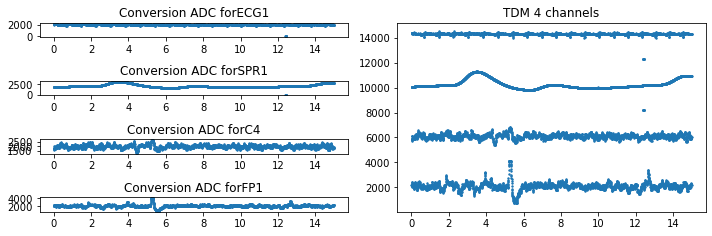

In [37]:
#!/usr/bin/env python3
%reload_ext autoreload
%autoreload 2


import io, os, sys
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as cp

'''````````````````````````````````````
SOURCE SOME MODULES
````````````````````````````````````'''

basepath = 'x-heep-femu-sdk/sw/arm/sdk/adc-emu/'

sys.path.append(os.path.abspath(basepath + '/src'))
from timeseries import *
from processes import *
from adc_emu import *

'''````````````````````````````````````
GENERAL DEFINITIONS
````````````````````````````````````'''
CHANNELS = 10
processes = []

'''````````````````````````````````````
PLOT EACH CHANNEL
````````````````````````````````````'''
def add_to_plot(series, row, col, channel_count, alpha=1):
    ax = plt.subplot2grid((CHANNELS, 2), (row, col), rowspan = 1 if col == 0 else channel_count )
    ax.set_title(series.name)
    ax.scatter(series.time, series.data, alpha = alpha, s=2  )
    processes.append(series)

'''````````````````````````````````````
READ THE INPUT FILE 
in the following format

Time,FP1,FP2,C3,C4,O1,O2,SPR1,SPR2,ECG1,ECG2
0.005,86.512,-61.877,73.345,-196.646,120.742,-10.405,-121.088,-6.189,1.378,-24.799
0.010,54.116,-194.703,32.428,-161.863,129.175,65.907,-121.581,-27.004,22.375,-29.840
````````````````````````````````````'''
with open(basepath+'in/multimodal/S1_ADAS1.txt') as f: y = f.readlines()
titles = y[0].strip().split(',')
y = y[1:]
data = np.asarray([[float(f) for f in l.split(',')] for l in y])


'''````````````````````````````````````
GET THE CHANNEL VALUES
````````````````````````````````````'''
channels = []
for i in range(len(titles)):
    channels.append([row[i] for row in data])


'''````````````````````````````````````
GENERATE A TIME SCALE
````````````````````````````````````'''
time = channels[0]
channels = channels[1:]
titles = titles[1:]
T_s = time[1] - time[0]
f_Hz = 1/T_s

'''````````````````````````````````````
CROP THE SIGNAL TO AN STIPULATED LENGTH
````````````````````````````````````'''
length_s = 15
sample_max = int(length_s/T_s)
for c in range(len(channels)): channels[c] = channels[c][:sample_max]


'''````````````````````````````````````
CREATE THE FIGURE BEFORE PLOTTING
````````````````````````````````````'''
fig = plt.figure()
fig.set_size_inches(10, 8)


'''````````````````````````````````````
SELECT CHANNELS THAT WILL BE PASSED
````````````````````````````````````'''
channels_to_plot = ['FP1', 'C4', 'SPR1', 'ECG1']
indexes = [titles.index(element) for element in channels_to_plot]
channel_count = len(indexes)

'''````````````````````````````````````
GENERATE THE ADCs FOR EACH CHANNEL
````````````````````````````````````'''
adc_channels = []
for ch_idx, ch_count in zip(indexes, range(len(indexes))):

    adc_channels.append( ADC( name      = f"ADC for{titles[ch_idx]}",
                            units       = "uV",
                            f_sample_Hz = f_Hz,
                            ampl_bits   = 12,
                            dynRange    = [-1500, 1500],
                            series      =  Timeseries(f"{titles[ch_idx]}",
                                                      channels[ch_idx],
                                                      length_s = length_s)
                            )
                        )
    add_to_plot(adc_channels[ch_count].conversion, channel_count - ch_count -1, 0, channel_count)

'''````````````````````````````````````
GENERATE THE MULTICHANNEL ADC
````````````````````````````````````'''
mcadc = mcADC("MultiChannel ADC", adc_channels[:CHANNELS] )
mcadc.TDM()
add_to_plot(mcadc.conversion, 0, 1, channel_count )


'''````````````````````````````````````
GENERAL PLOT SETTINGS
````````````````````````````````````'''
plt.subplots_adjust(hspace=2)
plt.tight_layout()
plt.show()

In [1]:
'''````````````````````````````````````
EXPORT THE CONVERTED SIGNAL
````````````````````````````````````'''
# mcadc.conversion.dump(path="out/")
mcadc.conversion.export_bin(path="out/", bytes=2, bigendian=True)

NameError: name 'mcadc' is not defined